In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import torch
import torch.nn as nn
import tensorflow as tf

from tensorflow.python.client import device_lib
from tensorflow import keras
from torchvision import models

from keras.layers import Dense
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.layers import Conv2D, MaxPooling2D, Flatten
from keras import backend as K
from keras.callbacks import EarlyStopping as ES
from keras.callbacks import ModelCheckpoint
from keras.applications import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.metrics import MeanIoU

from sklearn.model_selection import train_test_split

In [55]:
# The German Traffic Sign Recognition Benchmark
#
# sample code for reading the traffic sign images and the
# corresponding labels
#
# example:
#            
# trainImages, trainLabels = readTrafficSigns('GTSRB/Training')
# print len(trainLabels), len(trainImages)
# plt.imshow(trainImages[42])
# plt.show()
#
# have fun, Christian

# function for reading the images
# arguments: path to the traffic sign data, for example './GTSRB/Training'
# returns: list of images, list of corresponding labels 
def readTrafficSigns(rootpath):
    '''Reads traffic sign data for German Traffic Sign Recognition Benchmark.

    Arguments: path to the traffic sign data, for example './GTSRB/Training'
    Returns:   list of images, list of corresponding labels'''
    images = [] # images
    boundary = []
    labels = [] # corresponding labels
    # loop over all 42 classes
    for c in range(0,43):
        prefix = rootpath + '/' + format(c, '05d') + '/' # subdirectory for class
        gtFile = open(prefix + 'GT-'+ format(c, '05d') + '.csv') # annotations file
        gtReader = csv.reader(gtFile, delimiter=';') # csv parser for annotations file
        next(gtReader) # skip header
        # loop over all images in current annotations file
        for row in gtReader:
            images.append(plt.imread(prefix + row[0])) # the 1th column is the filename
            labels.append(row[7]) # the 8th column is the label
            boundary.append(row[3:7])
        gtFile.close()
    return images, boundary, labels


In [56]:

train_Examples, train_boundary, train_labels = readTrafficSigns('C:/Users/frank/Documents/AI Project/GTSRB/Final_Training/Images')

train_Examples = np.asarray(train_Examples)
train_boundary = np.asarray(train_boundary)
train_labels = np.asarray(train_labels)

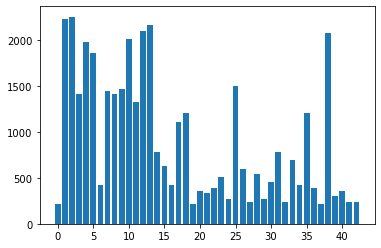

In [57]:
lb = train_labels.astype(np.int)
unique, counts = np.unique(lb, return_counts=True)
plt.bar(unique, counts)
plt.xticks(np.arange(43, step = 5))
plt.show()

In [58]:
#Process the data, we are only interested in images that are lass than 101 pixels wide and tall
count = 0
for i in range(len(train_Examples)):
    rows, columns, rgb = train_Examples[i].shape
    if rows < 101 and columns < 101:
        count+=1

data = np.zeros((count,100,100,3), dtype=int)

iterator = 0

for i in range(len(train_Examples)):
    
    rows,columns,rgb = train_Examples[i].shape
    
    value = train_Examples[i]
    
    if rows < 101 and columns < 101:
    
        for j in range(rows):
        
            for n in range(columns):
            
                for k in range(rgb):
                    data[iterator,j,n,k] = value[j,n,k]
                    #print(value[j,n,k])
        iterator += 1
        
labels = np.zeros((count,1))
boundary = np.zeros((count,4))

iterator = 0

for i in range(len(train_Examples)):
    x = train_Examples[i]
    row,column,rgb = x.shape
    
    if row < 101 and column < 101:
        labels[iterator,0] = train_labels[i]
        boundary[iterator, 0] = int(train_boundary[i,0])/100 #divide by 100 to put it in range of the sigmoid function
        boundary[iterator, 1] = int(train_boundary[i,1])/100
        boundary[iterator, 2] = int(train_boundary[i,2])/100
        boundary[iterator, 3] = int(train_boundary[i,3])/100
        iterator += 1
        
n_classes = 43

denseTrainData = data.reshape(count, 100*100*3).astype('float32')

categoricalLabels = keras.utils.to_categorical(labels, n_classes)


<function matplotlib.pyplot.show(*args, **kw)>

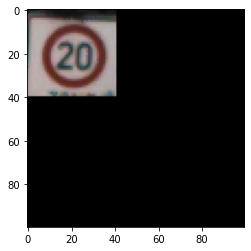

In [53]:
fig,ax = plt.subplots(1)

img = data[100][:][:][:][:]
    
ax.imshow(img)

plt.show

In [59]:
class EarlyStoppingAtMinLoss(keras.callbacks.Callback):
    """Stop training when the loss is at its min, i.e. the loss stops decreasing.

  Arguments:
      patience: Number of epochs to wait after min has been hit. After this
      number of no improvement, training stops.
  """

    def __init__(self, patience=5):
        super(EarlyStoppingAtMinLoss, self).__init__()
        self.patience = patience
        # best_weights to store the weights at which the minimum loss occurs.
        self.best_weights = None

    def on_train_begin(self, logs=None):
        # The number of epoch it has waited when loss is no longer minimum.
        self.wait = 0
        # The epoch the training stops at.
        self.stopped_epoch = 0
        # Initialize the best as infinity.
        self.best = np.Inf

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get("loss")
        if np.less(current, self.best):
            self.best = current
            self.wait = 0
            # Record the best weights if current results is better (less).
            self.best_weights = self.model.get_weights()
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                print("Restoring model weights from the end of the best epoch.")
                self.model.set_weights(self.best_weights)

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print("Epoch %05d: early stopping" % (self.stopped_epoch + 1))

In [60]:
#Split data for the dense models
x_train, x_valid, y_train, y_valid = train_test_split(denseTrainData, categoricalLabels, test_size=0.2, shuffle= True)
x_trainBB, x_validBB, y_trainBB, y_validBB = train_test_split(denseTrainData, boundary, test_size=0.2, shuffle= True)

In [61]:
n_classes = 43

denseClassifier = keras.Sequential()
denseClassifier.add(Dense(128, activation='relu', input_shape=(100*100*3,)))
denseClassifier.add(BatchNormalization())
denseClassifier.add(Dense(128, activation='relu'))
denseClassifier.add(BatchNormalization())
denseClassifier.add(Dropout(0.5))
denseClassifier.add(Dense(128, activation='relu'))
denseClassifier.add(BatchNormalization())
denseClassifier.add(Dropout(0.5))
denseClassifier.add(Dense(128, activation='relu'))
denseClassifier.add(BatchNormalization())
denseClassifier.add(Dense(n_classes, activation='softmax'))

In [62]:
denseBB = keras.Sequential()
denseBB.add(Dense(128, activation='relu', input_shape=(100*100*3,)))
denseBB.add(BatchNormalization())
denseBB.add(Dense(64, activation='relu'))
denseBB.add(BatchNormalization())
denseBB.add(Dropout(0.5))
denseBB.add(Dense(32, activation='relu'))
denseBB.add(BatchNormalization())
denseBB.add(Dropout(0.5))
denseBB.add(Dense(128, activation='relu'))
denseBB.add(BatchNormalization())
denseBB.add(Dense(4, activation='sigmoid'))

In [63]:
#Hyper Parameters
denseOpt = keras.optimizers.Adam(learning_rate=0.001)
BBopt = keras.optimizers.Adam(learning_rate=0.0001)

loss_Dense = 'categorical_crossentropy'
loss_BB = 'mse'

#Compile Model

denseClassifier.compile(loss=loss_Dense,optimizer=denseOpt,metrics=['accuracy'])
denseBB.compile(loss=loss_BB,optimizer=BBopt,metrics=['mse'])


In [64]:
DenseBBMC = ModelCheckpoint('C:/Users/frank/Documents/AI Project/DenseModelBB.h5', monitor='val_loss')
DenseClassifierMC = ModelCheckpoint('C:/Users/frank/Documents/AI Project/DenseModelLastMinute.h5', monitor='val_loss')

In [98]:
#Train Dense Bounding Box

denseBBHistory = denseBB.fit(x_trainBB,y_trainBB, batch_size=128, epochs=100, validation_data=(x_validBB, y_validBB), callbacks=[EarlyStoppingAtMinLoss(), DenseBBMC])

Epoch 1/100
232/232 [==============================] - 6s 26ms/step - loss: 0.1182 - mse: 0.1182 - val_loss: 0.0643 - val_mse: 0.0643
Epoch 2/100
232/232 [==============================] - 6s 25ms/step - loss: 0.0754 - mse: 0.0754 - val_loss: 0.0363 - val_mse: 0.0363
Epoch 3/100
232/232 [==============================] - 6s 25ms/step - loss: 0.0479 - mse: 0.0479 - val_loss: 0.0292 - val_mse: 0.0292
Epoch 4/100
232/232 [==============================] - 6s 25ms/step - loss: 0.0336 - mse: 0.0336 - val_loss: 0.0184 - val_mse: 0.0184
Epoch 5/100
232/232 [==============================] - 6s 25ms/step - loss: 0.0256 - mse: 0.0256 - val_loss: 0.0137 - val_mse: 0.0137
Epoch 6/100
232/232 [==============================] - 6s 26ms/step - loss: 0.0208 - mse: 0.0208 - val_loss: 0.0113 - val_mse: 0.0113
Epoch 7/100
232/232 [==============================] - 6s 25ms/step - loss: 0.0182 - mse: 0.0182 - val_loss: 0.0117 - val_mse: 0.0117
Epoch 8/100
232/232 [==============================] - 6s 25ms

In [65]:
#Train Dense Classifier and save history for graphing

denseClassifierHistory = denseClassifier.fit(x_train, y_train, batch_size=128, epochs=18, validation_data=(x_valid, y_valid), callbacks=[EarlyStoppingAtMinLoss(), DenseClassifierMC])

Epoch 1/18
232/232 [==============================] - 15s 66ms/step - loss: 3.6643 - accuracy: 0.0865 - val_loss: 3.1377 - val_accuracy: 0.1460
Epoch 2/18
232/232 [==============================] - 6s 26ms/step - loss: 2.9136 - accuracy: 0.1844 - val_loss: 2.4748 - val_accuracy: 0.2606
Epoch 3/18
232/232 [==============================] - 6s 25ms/step - loss: 2.4534 - accuracy: 0.2646 - val_loss: 2.3312 - val_accuracy: 0.2915
Epoch 4/18
232/232 [==============================] - 6s 25ms/step - loss: 2.1713 - accuracy: 0.3294 - val_loss: 1.9667 - val_accuracy: 0.3748
Epoch 5/18
232/232 [==============================] - 6s 25ms/step - loss: 1.9837 - accuracy: 0.3754 - val_loss: 1.7290 - val_accuracy: 0.4560
Epoch 6/18
232/232 [==============================] - 6s 25ms/step - loss: 1.8618 - accuracy: 0.4029 - val_loss: 1.8063 - val_accuracy: 0.4293
Epoch 7/18
232/232 [==============================] - 6s 25ms/step - loss: 1.7200 - accuracy: 0.4488 - val_loss: 1.6305 - val_accuracy: 0.485

In [66]:
denseClassifier.evaluate(x_valid, y_valid)

232/232 [==============================] - 1s 3ms/step - loss: 1.2656 - accuracy: 0.5927


[1.2655881643295288, 0.5926924347877502]

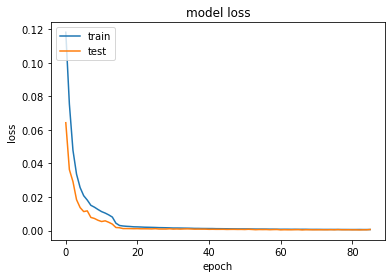

In [101]:
#Graph Dense Bounding Box Loss
plt.plot(denseBBHistory.history['loss'])
plt.plot(denseBBHistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('C:/Users/frank/Documents/AI Project/Figures/DenseBBLoss.png')
plt.show()

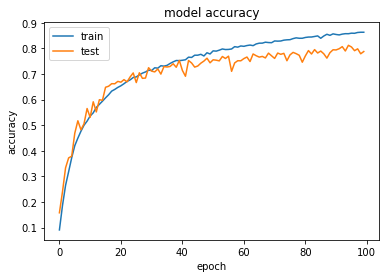

In [125]:
#Graph Dense Classifier Accuracy
plt.plot(denseClassifierHistory.history['accuracy'])
plt.plot(denseClassifierHistory.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('C:/Users/frank/Documents/AI Project/Figures/DenseClassifierAccuracy.png')
plt.show()

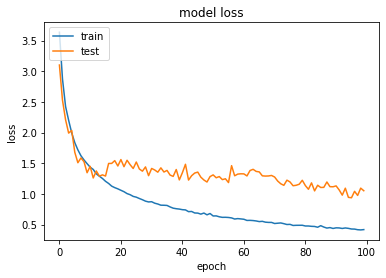

In [126]:
#Graph Dense Classifier Loss
plt.plot(denseClassifierHistory.history['loss'])
plt.plot(denseClassifierHistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('C:/Users/frank/Documents/AI Project/Figures/DenseClassifierLoss.png')
plt.show()

In [133]:
#Process the data for the CNN for image and bounding box jobs
x_train_conv, x_valid_conv, y_train_conv, y_valid_conv = train_test_split(data, categoricalLabels, test_size=0.2, shuffle= True)

x_train_conv_bb, x_valid_conv_bb, y_train_conv_bb, y_valid_conv_bb = train_test_split(data, boundary, test_size=0.2, shuffle= True)

In [144]:
#Hyper Parameters

#CNN Classifier
conv_opt = 'adam'
conv_loss = 'categorical_crossentropy'
conv_metrics = ['accuracy']

#CNN Bounding Box 
conv_bb_opt = keras.optimizers.Adam(learning_rate=0.0001)
conv_bb = 'mse'
conv_bb_metrics = ['loss']

In [145]:
#CNN Classifier

model_conv = keras.Sequential()
model_conv.add(Conv2D(32, kernel_size=(3, 3),activation='relu', input_shape=(100, 100, 3)))
model_conv.add(MaxPooling2D(pool_size=(2, 2)))

model_conv.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model_conv.add(MaxPooling2D(pool_size=(2, 2)))
model_conv.add(BatchNormalization())

model_conv.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model_conv.add(MaxPooling2D(pool_size=(2, 2)))
model_conv.add(BatchNormalization())
model_conv.add(Dropout(0.25))

model_conv.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model_conv.add(MaxPooling2D(pool_size=(2, 2)))
model_conv.add(BatchNormalization())
model_conv.add(Dropout(0.5))

model_conv.add(Flatten())
model_conv.add(Dense(128, activation='relu'))
model_conv.add(Dropout(0.5))
model_conv.add(Dense(n_classes, activation='softmax')) #classifier

In [146]:
#CNN Bounding Box Predicter

conv_bb = keras.Sequential()
conv_bb.add(Conv2D(32, kernel_size=(3, 3),activation='relu', input_shape=(100, 100, 3)))
conv_bb.add(MaxPooling2D(pool_size=(2, 2)))
conv_bb.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
conv_bb.add(MaxPooling2D(pool_size=(2, 2)))
conv_bb.add(BatchNormalization())
conv_bb.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
conv_bb.add(MaxPooling2D(pool_size=(2, 2)))
conv_bb.add(BatchNormalization())
conv_bb.add(Dropout(0.25))
conv_bb.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
conv_bb.add(MaxPooling2D(pool_size=(2, 2)))
conv_bb.add(BatchNormalization())
conv_bb.add(Dropout(0.5))
conv_bb.add(Flatten())
conv_bb.add(Dense(128, activation='relu'))
conv_bb.add(Dropout(0.5))
conv_bb.add(Dense(4, activation='sigmoid')) #classifier

In [147]:
#Compile Models

model_conv.compile(loss=conv_loss,optimizer=conv_opt,metrics=conv_metrics)

conv_bb.compile(loss=conv_loss,optimizer=conv_opt,metrics=conv_metrics)

In [148]:
#Create checkpoints

convMC = ModelCheckpoint('C:/Users/frank/Documents/AI Project/convModel.h5', monitor='val_accuracy')

convBB = ModelCheckpoint('C:/Users/frank/Documents/AI Project/convBB.h5', monitor='val_loss')

In [149]:
#train model
convClassifierHistory = model_conv.fit(x_train_conv, y_train_conv, batch_size=128, epochs=100, validation_data=(x_valid_conv, y_valid_conv), callbacks=[EarlyStoppingAtMinLoss(), convMC])

Epoch 1/100
232/232 [==============================] - 207s 893ms/step - loss: 3.5856 - accuracy: 0.0885 - val_loss: 3.0535 - val_accuracy: 0.1540
Epoch 2/100
232/232 [==============================] - 206s 887ms/step - loss: 2.6045 - accuracy: 0.2359 - val_loss: 2.1588 - val_accuracy: 0.3480
Epoch 3/100
232/232 [==============================] - 206s 888ms/step - loss: 1.7708 - accuracy: 0.4191 - val_loss: 1.9943 - val_accuracy: 0.4355
Epoch 4/100
232/232 [==============================] - 206s 886ms/step - loss: 1.3005 - accuracy: 0.5605 - val_loss: 0.8832 - val_accuracy: 0.7212
Epoch 5/100
232/232 [==============================] - 205s 885ms/step - loss: 0.9257 - accuracy: 0.6942 - val_loss: 0.4892 - val_accuracy: 0.8533
Epoch 6/100
232/232 [==============================] - 206s 886ms/step - loss: 0.6329 - accuracy: 0.7906 - val_loss: 0.3123 - val_accuracy: 0.9064
Epoch 7/100
232/232 [==============================] - 206s 886ms/step - loss: 0.4665 - accuracy: 0.8483 - val_loss: 0

In [150]:
#train model
convBBHistory = conv_bb.fit(x_train_conv_bb, y_train_conv_bb, batch_size=128, epochs=100, validation_data=(x_valid_conv_bb, y_valid_conv_bb))#, callbacks=[EarlyStoppingAtMinLoss(), convBB])

Epoch 1/100
232/232 [==============================] - 207s 892ms/step - loss: 1.0300 - accuracy: 0.5550 - val_loss: 0.9999 - val_accuracy: 0.6229
Epoch 2/100
232/232 [==============================] - 205s 886ms/step - loss: 0.9999 - accuracy: 0.5593 - val_loss: 0.9951 - val_accuracy: 0.6221
Epoch 3/100
232/232 [==============================] - 205s 886ms/step - loss: 0.9977 - accuracy: 0.5667 - val_loss: 0.9943 - val_accuracy: 0.6234
Epoch 4/100
232/232 [==============================] - 206s 888ms/step - loss: 0.9964 - accuracy: 0.5800 - val_loss: 0.9942 - val_accuracy: 0.6199
Epoch 5/100
232/232 [==============================] - 206s 887ms/step - loss: 0.9959 - accuracy: 0.5800 - val_loss: 0.9938 - val_accuracy: 0.6246
Epoch 6/100
232/232 [==============================] - 206s 888ms/step - loss: 0.9952 - accuracy: 0.5876 - val_loss: 0.9939 - val_accuracy: 0.6251
Epoch 7/100
232/232 [==============================] - 206s 887ms/step - loss: 0.9948 - accuracy: 0.5846 - val_loss: 0

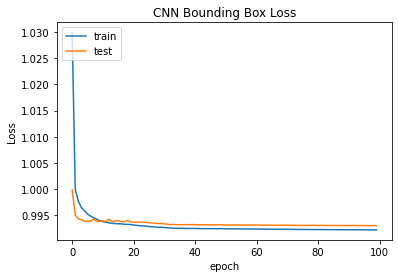

In [159]:
#Graph CNN Bounding Box Loss
plt.plot(convBBHistory.history['loss'])
plt.plot(convBBHistory.history['val_loss'])
plt.title('CNN Bounding Box Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('C:/Users/frank/Documents/AI Project/Figures/ConvBBLoss.png')
plt.show()

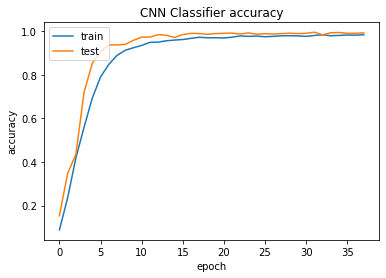

In [157]:
#Graph CNN Classifier Accuracy
plt.plot(convClassifierHistory.history['accuracy'])
plt.plot(convClassifierHistory.history['val_accuracy'])
plt.title('CNN Classifier accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('C:/Users/frank/Documents/AI Project/Figures/ConvClassifierAccuracy.png')
plt.show()

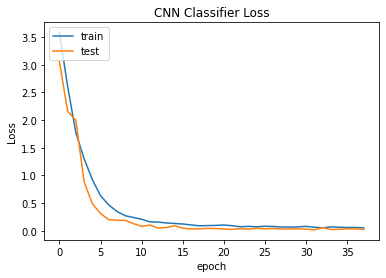

In [160]:
#Graph CNN Classifier Loss
plt.plot(convClassifierHistory.history['loss'])
plt.plot(convClassifierHistory.history['val_loss'])
plt.title('CNN Classifier Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('C:/Users/frank/Documents/AI Project/Figures/ConvClassifierLoss.png')
plt.show()